# Assignment 3: Modern Deep Architectures

In [28]:
import pickle
from os import getcwd
from os.path import join
from itertools import product
from IPython.display import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pandas.plotting import table
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer

import ray
from ray import tune, train
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
from ray.air.integrations.keras import ReportCheckpointCallback

import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Task a
Load and prepare your data and labels. Familiarize yourself with the dataset and problem. Construct a stratified validation set consisting of samples from the training data, which will be used during the model selection process. You will use the test set only for final evaluations.

### Load data

In [67]:
(x, y), (x_test, y_test) = cifar100.load_data(label_mode="coarse")
print(x.shape, y.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


### Describe data

In [48]:
classes_df = pd.DataFrame(data=y, columns=["label"])
classes_df["label"] = classes_df["label"].astype(str)
classes_df.describe()

,label
count,50000
unique,20
top,11
freq,2500


Text(0.5, 1.0, 'The number of images for each class')

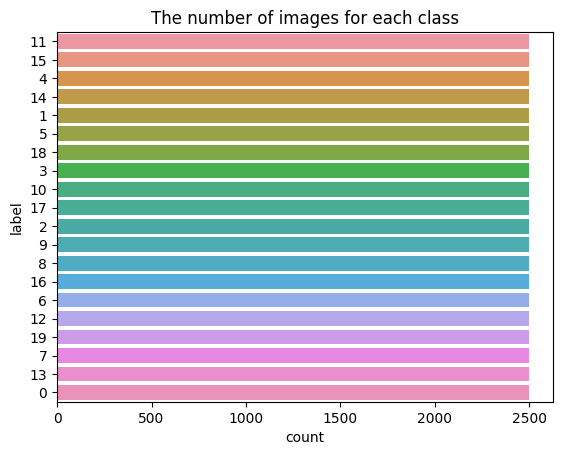

In [49]:
sns.countplot(y=classes_df["label"]).set_title("The number of images for each class")

We have 20 and we can not show it in one board. So we have decided to split it into 4 parts and show in 4 cells outputs. This function takes the list of unique classes that should be shown and show a board with unique class per row and 5 images per class in a row.

In [50]:
def show_class_photos(unique_classes, photos_to_show_per_class=5):
    rows = len(unique_classes) 

    fig = plt.figure(constrained_layout=True)
    row_subfigs = fig.subfigures(nrows=rows, ncols=1)

    for every_row_subfigure, every_class in zip(row_subfigs, unique_classes):
        every_row_subfigure.suptitle(every_class)
        class_positions = np.where(y==every_class)[0]
        random_images_positions = np.random.choice(class_positions, size=photos_to_show_per_class)
        chosen_images = x[random_images_positions, :]
        column_subplots = every_row_subfigure.subplots(nrows=1, ncols=photos_to_show_per_class)
        for every_column_subplot, every_image_array in zip(column_subplots, chosen_images):
            every_column_subplot.axis('off')
            every_column_subplot.imshow(every_image_array, cmap="gray")

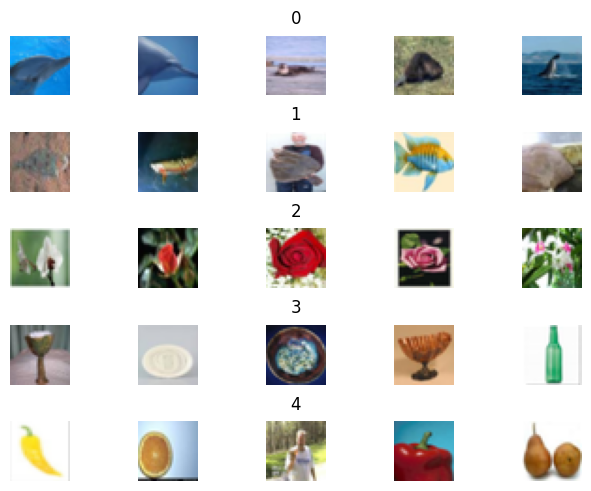

In [51]:
show_class_photos(unique_classes[:5])

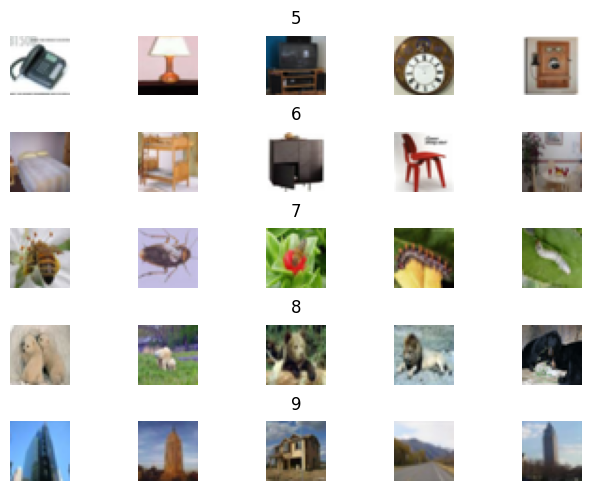

In [52]:
show_class_photos(unique_classes[5:10])

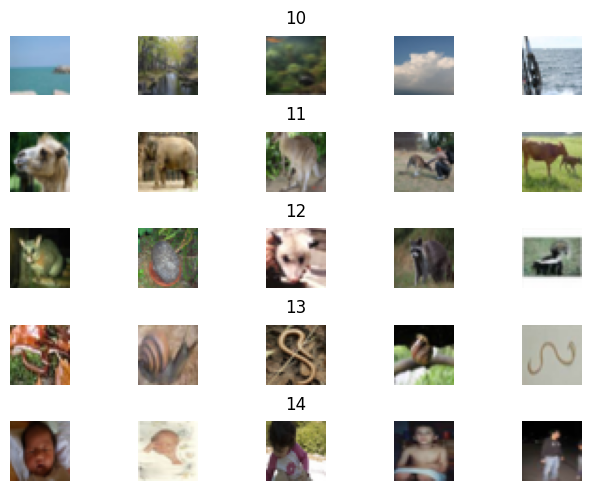

In [53]:
show_class_photos(unique_classes[10:15])

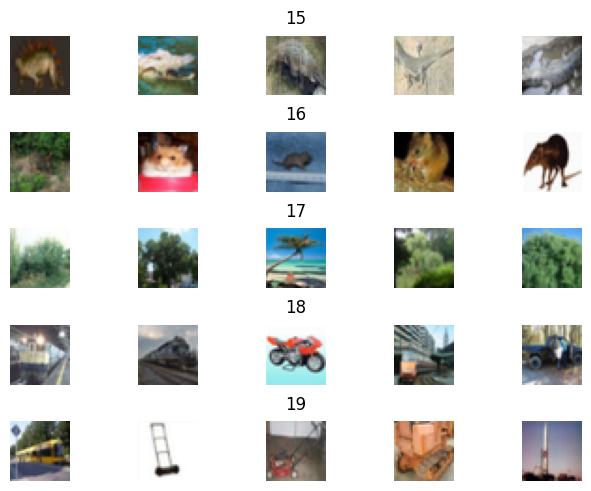

In [54]:
show_class_photos(unique_classes[15:])

In [55]:
pixels_stats = pd.Series(
    data=[
        np.mean(x),
        np.min(x),
        np.max(x),
        np.var(x),
        np.std(x),
        np.ptp(x)
    ],
    index=["mean", "mean", "max", "var", "std_dev", "range"]
)
pixels_stats

mean        121.936059
mean          0.000000
max         255.000000
var        4677.049383
std_dev      68.388957
range       255.000000
dtype: float64

### Preprocess

In [2]:
def data_pipe(x_data, y_data):
    x_data = np.mean(x_data, axis=3)
    x_data = np.expand_dims(x_data, axis=-1)
    x_data = x_data.astype(np.float64)
    y_data = y_data.flatten()
    return x_data, y_data

In [69]:
x, y = data_pipe(x, y)
x_test, y_test = data_pipe(x_test, y_test)
print(x.shape, y.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 1) (50000,) (10000, 32, 32, 1) (10000,)


In [70]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(40000, 32, 32, 1) (40000,) (10000, 32, 32, 1) (10000,)


One-hot class vectors

In [71]:
binarizer = LabelBinarizer()
y_train_one_hot = binarizer.fit_transform(y_train)
y_val_one_hot = binarizer.transform(y_val)
y_test_one_hot = binarizer.transform(y_test)
y_one_hot = binarizer.transform(y)
print(y_train_one_hot.shape, y_val_one_hot.shape, y_test_one_hot.shape)

(40000, 20) (10000, 20) (10000, 20)


Normalize

In [72]:
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0
x /= 255.0

## Task b
Design and train your customized CNN for this multi-class classifi-
cation task, that achieves good performance on the grayscale CIFAR-20 test
set. Explain your choices for the output layer and the error function that you
will use. During training with mini-batches, use early stopping based on the
validation set to avoid overfitting. Test different architectures with varying
numbers of convolutional layers and number of kernels (i.e., change the archi-
tecture in depth and width). Compare training and validation set errors and
accuracies of (at least five) different architectures and report in a table.

### Train naive

The output layer is the `Dense` layer with number of classes as number of output neurons and `categorical cross entropy` as loss function for multiclass classification problem. 

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu', input_shape=x_train.shape[1:]),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(unique_classes.shape[0], activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                   

2023-12-19 00:58:26.577918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [ ]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x_train, y_train_one_hot,
    validation_data=(x_val, y_val_one_hot),
    epochs=50, batch_size=512,
    shuffle=True,
    verbose=0,
    callbacks=[early_stop_callback]
)

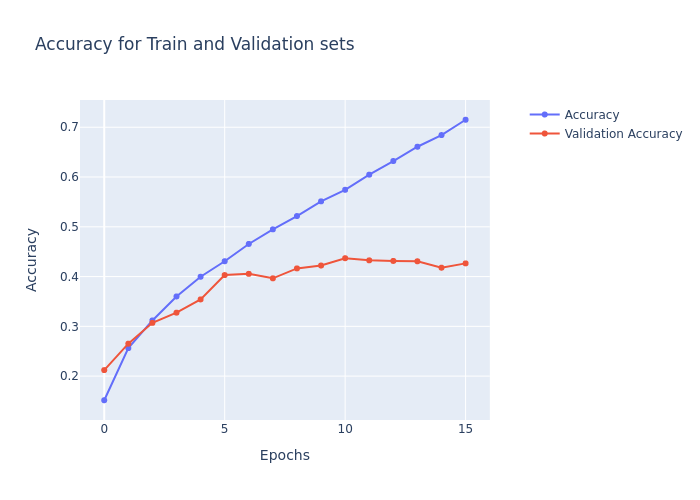

In [11]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="Accuracy"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="Validation Accuracy"),
    secondary_y=False,
)

fig.update_layout(
    title_text="Accuracy for Train and Validation sets"
)

fig.update_xaxes(title_text="Epochs")

fig.update_yaxes(title_text="Accuracy", secondary_y=False)

Image(fig.to_image(format="png"))

### Architecture

So here we go again with the tuning processes. Unfortunately, the `ray` tuner serilizes data used inside training function together with code so we need to unpack data every time we train a model. The `train_architecture` function builds and fits a model which is configured by the `config` parameter. It has $int$ `layers`, $list$ `filters` and $list$ `kernels` params.

In [61]:
def get_data():
    (x, y), (_, _) = cifar100.load_data(label_mode="coarse")
    x, y = data_pipe(x, y)
    
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

    binarizer = LabelBinarizer()
    y_train_one_hot = binarizer.fit_transform(y_train)
    y_val_one_hot = binarizer.transform(y_val)

    x_train /= 255.0
    x_val /= 255.0
    return x_train, y_train_one_hot, x_val, y_val_one_hot

In [13]:
def train_architectures(config):
    batch_size = 512
    epochs = 30

    # define data
    x_train, y_train_one_hot, x_val, y_val_one_hot = get_data()

    conv_layers = []
    for index, (filters, kernels) in enumerate(list(zip(config["filters"], config["kernels"]))):
        if index == 0:
            conv_layers.append(
                tf.keras.layers.Conv2D(filters, (kernels, kernels), padding="same", activation='relu', input_shape=x_train.shape[1:]))
            continue

        conv_layers.append(
            tf.keras.layers.Conv2D(filters, (kernels, kernels), padding="same", activation='relu'))

        if index % 2 == 1 and index + 1 != config["layers"]:
            conv_layers.append(tf.keras.layers.MaxPooling2D())

    conv_layers.append(tf.keras.layers.MaxPooling2D())
    
    model = tf.keras.Sequential([
        *conv_layers,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(20, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    model.fit(
        x_train, y_train_one_hot,
        validation_data=(x_val, y_val_one_hot),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[
            ReportCheckpointCallback(metrics={"Accuracy": "val_accuracy"}),
            early_stop_callback
        ]
    )

We have three params: number of layers, number of filters in each layer, size of the conv kernel for each layer. And it does not mean that last 2 params will be same for each layer. This tuner searches for the highest accuracy for the model with $1-4$ possible layers, each layer can have $8/16/32/64$ filters with $2/3/4$ conv sizes for each layer. We also would like to put pooling layers after each two conv layers and at the end of the layers list.

In [14]:
def tune_architectures():
    algo = OptunaSearch()
    algo = ConcurrencyLimiter(algo, max_concurrent=3)
    tuner = tune.Tuner(
        tune.with_resources(train_architectures, resources={"cpu": 2, "gpu": 1}),
        tune_config=tune.TuneConfig(
            metric="Accuracy",
            mode="max",
            num_samples=3000,
            search_alg=algo
        ),
        run_config=train.RunConfig(
            local_dir="/ray",
        ),
        param_space={
            "layers": tune.choice([1, 2, 3, 4]),
            "filters": tune.sample_from(lambda spec: np.random.choice(np.array([8, 16, 32, 64]), size=spec.config.layers)),
            "kernels": tune.sample_from(lambda spec: np.random.choice(np.array([2, 3, 4]), size=spec.config.layers))
        },
    )
    results = tuner.fit()
    df = results.get_dataframe(filter_metric="Accuracy", filter_mode="max")[["Accuracy", "config/layers", "config/filters", "config/kernels"]].sort_values(by=["Accuracy"], ascending=False)
    df.to_csv("architectures.csv")

Starting the whole process.

In [15]:
%%capture
ray.init(ignore_reinit_error=True, log_to_driver=False, logging_level="ERROR")

In [16]:
%%capture
tune_architectures()

In [17]:
%%capture
ray.shutdown()

After the process is finished - read results from the disk

In [32]:
df = pd.read_csv("architectures.csv").groupby(["config/layers", "config/filters", "config/kernels"]).mean().sort_values(by=["Accuracy"], ascending=False)[["Accuracy"]].head()

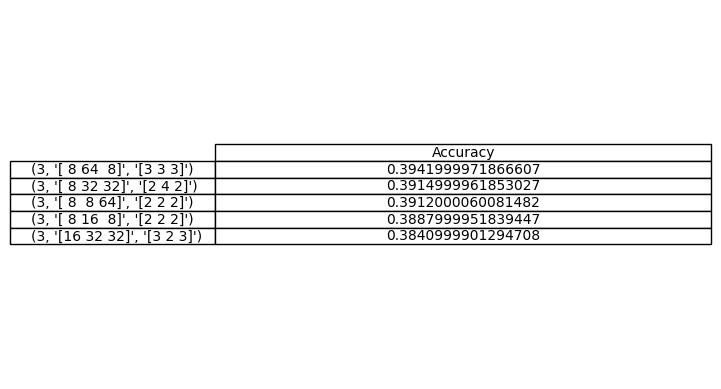

In [33]:
fix, ax = plt.subplots()
ax.axis('off')
table = pd.plotting.table(ax, df, loc='center', cellLoc='center')

So the layer with the architecture:
$$
Conv2D(8, 3) \\
Conv2D(64, 3) \\
MaxPooling() \\
Conv2D(8, 3) \\
MaxPooling() \\
Dense(128) \\
Dense(20)
$$

got the most accuracy $0.3942$.

## Task c
Investigate and compare different layer weight regularizers and dropout
for regularization. You should use the validation set to find the appropri-
ate regularization hyper-parameters (e.g., l 2 -regularization weight, or a good
dropout rate). Provide a table where training and validation set errors and
accuracies of various regularization settings are compared.

### Legularization

Here is the regularization tuning. We will define classes and rates for regularization for each layer. Also we will define different dropout rates. 

In [16]:
def define_regularizer(reg_class, value):
    if isinstance(reg_class, tf.keras.regularizers.L1L2):
        return reg_class(*value)
    else:
        return reg_class(value)

In [17]:
def train_regularizers(config):
    batch_size = 512
    epochs = 30

    # define data
    x_train, y_train_one_hot, x_val, y_val_one_hot = get_data()
    
    reg_1 = define_regularizer(config["layer_1_reg_class"], config["layer_1_reg_value"])
    reg_2 = define_regularizer(config["layer_2_reg_class"], config["layer_2_reg_value"])
    reg_3 = define_regularizer(config["layer_3_reg_class"], config["layer_3_reg_value"])

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 3, padding="same", activation='relu', input_shape=x_train.shape[1:], kernel_regularizer=reg_1),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu', kernel_regularizer=reg_2),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(config["dropout_1"]),
        tf.keras.layers.Conv2D(8, 3, padding="same", activation='relu', kernel_regularizer=reg_3),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(config["dropout_2"]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(20, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    model.fit(
        x_train, y_train_one_hot,
        validation_data=(x_val, y_val_one_hot),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[
            ReportCheckpointCallback(metrics={"Accuracy": "val_accuracy"}),
            early_stop_callback
        ]
    )

In [18]:
def gen_reg_value(reg_class):
    if isinstance(reg_class, tf.keras.regularizers.L1L2):
        return [
            np.random.uniform(0.000001, 0.01),
            np.random.uniform(0.000001, 0.01)
        ]
    else:
        return np.random.uniform(0.000001, 0.01)

In [19]:
def tune_regularizers():
    algo = OptunaSearch()
    algo = ConcurrencyLimiter(algo, max_concurrent=3)
    tuner = tune.Tuner(
        tune.with_resources(train_regularizers, resources={"cpu": 2, "gpu": 1}),
        tune_config=tune.TuneConfig(
            metric="Accuracy",
            mode="max",
            num_samples=1000,
            search_alg=algo
        ),
        run_config=train.RunConfig(
            local_dir="/ray",
        ),
        param_space={
            "layer_1_reg_class": tune.choice([L1, L2, L1L2]),
            "layer_1_reg_value": tune.sample_from(lambda spec: gen_reg_value(spec.config.layer_1_reg_class)),
            "layer_2_reg_class": tune.choice([L1, L2, L1L2]),
            "layer_2_reg_value": tune.sample_from(lambda spec: gen_reg_value(spec.config.layer_2_reg_class)),
            "layer_3_reg_class": tune.choice([L1, L2, L1L2]),
            "layer_3_reg_value": tune.sample_from(lambda spec: gen_reg_value(spec.config.layer_3_reg_class)),
            "dropout_1": tune.uniform(0.0, 0.5),
            "dropout_2": tune.uniform(0.0, 0.5)
        },
    )
    results = tuner.fit()
    df = results.get_dataframe(filter_metric="Accuracy", filter_mode="max")[
        ["Accuracy", 
         "config/layer_1_reg_class", 
         "config/layer_1_reg_value", 
         "config/layer_2_reg_class", 
         "config/layer_2_reg_value", 
         "config/layer_3_reg_class", 
         "config/layer_3_reg_value", 
         "config/dropout_1", 
         "config/dropout_2"]
    ].sort_values(by=["Accuracy"], ascending=False)
    df.to_csv("regularizers.csv")

In [25]:
%%capture
ray.init(ignore_reinit_error=True, log_to_driver=False, logging_level="ERROR")

In [26]:
%%capture
tune_regularizers()

In [27]:
%%capture
ray.shutdown()

Unfortunately there are too many group parameters so we will show the first row only without Accuracy params.

In [48]:
index_keys = list(pd.read_csv("regularizers.csv").groupby(
    ["config/layer_1_reg_class", "config/layer_2_reg_class", "config/layer_3_reg_class", "config/layer_1_reg_value", "config/layer_2_reg_value", "config/layer_3_reg_value", "config/dropout_1", "config/dropout_2"]
).mean().sort_values(by=["Accuracy"], ascending=False)[["Accuracy"]].head(1).to_dict()["Accuracy"].keys())[0]

In [49]:
print(f"{index_keys[0]} - {index_keys[3]}")
print(f"{index_keys[1]} - {index_keys[4]}")
print(f"Dropout - {index_keys[6]}")
print(f"{index_keys[2]} - {index_keys[5]}")
print(f"Dropout - {index_keys[7]}")

<class 'keras.src.regularizers.L2'> - 0.0004610907872849
<class 'keras.src.regularizers.L2'> - 0.0034807954679991
Dropout - 0.0937549406716745
<class 'keras.src.regularizers.L2'> - 0.007048122737288
Dropout - 0.0957773496014178


We will show here the order of regularizers and dropouts in the model:
$$
L2(0.000461) \\
L2(0.003481) \\
Dropout(0.093755) \\
L2(0.007048) \\
Dropout(0.095777) \\
$$

## Task d
Summarize your final model architecture in detail (i.e., convolutional
and/or pooling kernel sizes and specifications, input and output dimension-
alities per layer, activation functions). Report your training specifications
regarding the loss function, optimization scheme and learning rate, batch size
and number of training epochs, and the amount of trainable parameters in
your network. Provide a plot where the evolution of the training and validation error during training is shown throughout iterations. Perform a final
training with the whole training set. Report the final test accuracy and a
confusion matrix of your test set predictions.

### Model Summary

First of all we will train model to check the number of epochs

In [73]:
epochs = 100
batch_size = 256

In [74]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 2, padding="same", activation='relu', input_shape=x_train.shape[1:], kernel_regularizer=L2(0.000461)),
    tf.keras.layers.Conv2D(32, 2, padding="same", activation='relu', kernel_regularizer=L2(0.003481)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.093755),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu', kernel_regularizer=L2(0.007048)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.095777),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(20, activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 16)        80        
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        2080      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                 

                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 20)                2580      
                                                                 
Total params: 276260 (1.05 MB)
Trainable params: 276260 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x_train, y_train_one_hot,
    validation_data=(x_val, y_val_one_hot),
    epochs=epochs, batch_size=batch_size,
    shuffle=True,
    verbose=0
)

2023-12-19 01:46:40.106337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


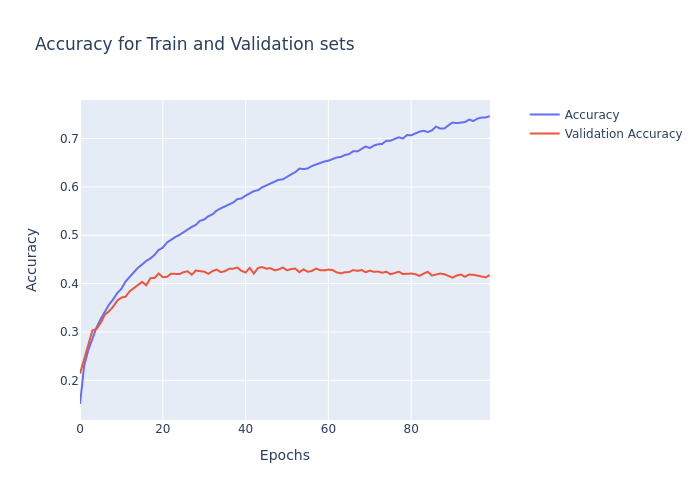

In [37]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="Accuracy"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="Validation Accuracy"),
    secondary_y=False,
)

fig.update_layout(
    title_text="Accuracy for Train and Validation sets"
)

fig.update_xaxes(title_text="Epochs")

fig.update_yaxes(title_text="Accuracy", secondary_y=False)

Image(fig.to_image(format="png"))

We can see that after around 20 epochs the model's calidation accuracy remains the same.

In [38]:
y_one_hot = y_one_hot.astype(np.float64)
y_test_one_hot = y_test_one_hot.astype(np.float64)

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.F1Score(average="weighted", name="f1_score")])
history = model.fit(
    x, y_one_hot,
    epochs=20, batch_size=batch_size,
    shuffle=True,
    verbose=0
)

2023-12-19 01:15:24.319131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [40]:
model.evaluate(x_test, y_test_one_hot)

313/313 [==============================] - 1s 2ms/step - loss: 2.3322 - accuracy: 0.4313 - f1_score: 0.4267


[2.332235813140869, 0.43130001425743103, 0.4267198443412781]

Accuracy: 0.43130001425743103

F1Score: 0.4267198443412781

## Task e
Now, evaluate your CNN from part (d), on the perturbed test set and
report the accuracy. Then, try and discuss different approaches (e.g., regu-
larization, batch normalization, data augmentation 2 , etc.) to achieve better
generalization of your model against such image perturbations. Demonstrate
in a single table the trade-offs between the training set, test set, and perturbed
test set accuracies under various modifications to your model. Present your
final architecture and optimization scheme clearly, and report the final train-
ing set, test set, and perturbed test set accuracies. You are not allowed to use
samples from the perturbed test set to fine-tune your model weights.

### Perturbed dataset

In [62]:
data = pickle.load(open("data.pkl", "rb"))
x_perturb, y_perturb = data["x_perturb"], data["y_perturb"]
x_perturb, y_perturb = data_pipe(x_perturb, y_perturb)
print(x_perturb.shape, y_perturb.shape)

(10000, 32, 32, 1) (10000,)


In [64]:
y_perturb_one_hot = binarizer.transform(y_perturb).astype(np.float64)
print(y_perturb_one_hot.shape)

(10000, 20)


In [65]:
model.evaluate(x_perturb, y_perturb_one_hot)

  1/313 [..............................] - ETA: 7s - loss: 2.5405 - accuracy: 0.3750 - f1_score: 0.3313

313/313 [==============================] - 1s 2ms/step - loss: 2.4841 - accuracy: 0.3889 - f1_score: 0.3864


[2.484119415283203, 0.3889000117778778, 0.38641735911369324]

Accuracy: 0.3889000117778778
F1Score: 0.38641735911369324

### Generalization approaches
We will use pretty same tune model we used before. But at this time each parameter of the model will be the full function itself. First of all we need a new data fuction which gives train, test, and perturbed test datasets.

In [3]:
DIR = getcwd()
DIR

'/home/jovyan'

In [4]:
def get_all_data():
    (x, y), (x_test, y_test) = cifar100.load_data(label_mode="coarse")
    data = pickle.load(open(join(DIR, "data.pkl"), "rb"))
    x_perturb, y_perturb = data["x_perturb"], data["y_perturb"]

    x, y = data_pipe(x, y)
    x_test, y_test = data_pipe(x_test, y_test)
    x_perturb, y_perturb = data_pipe(x_perturb, y_perturb)

    binarizer = LabelBinarizer()
    y_one_hot = binarizer.fit_transform(y)
    y_test_one_hot = binarizer.transform(y_test)
    y_perturb_one_hot = binarizer.transform(y_perturb)

    x /= 255.0
    x_test /= 255.0
    x_perturb /= 255.0

    return (x, y_one_hot), (x_test, y_test_one_hot), (x_perturb, y_perturb_one_hot)

A simple regularized model that we got in `d` task.

In [39]:
def regularized():
    (x, y_one_hot), (x_test, y_test_one_hot), (x_perturb, y_perturb_one_hot) = get_all_data()

    batch_size = 512
    epochs = 50

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, 2, padding="same", activation='relu', input_shape=x.shape[1:], kernel_regularizer=L2(0.000461)),
        tf.keras.layers.Conv2D(32, 2, padding="same", activation='relu', kernel_regularizer=L2(0.003481)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.093755),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu', kernel_regularizer=L2(0.007048)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.095777),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(20, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    model.fit(
        x, y_one_hot,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=0
    )

    _, train_accuracy = model.evaluate(x, y_one_hot)
    _, test_accuracy = model.evaluate(x_test, y_test_one_hot)
    _, perturb_accuracy = model.evaluate(x_perturb, y_perturb_one_hot)
    return {"Test Accuracy": test_accuracy, "Perturb Accuracy": perturb_accuracy, "Train Accuracy": train_accuracy}

This model will use batch normalization

In [13]:
def normalized_batches():
    (x, y_one_hot), (x_test, y_test_one_hot), (x_perturb, y_perturb_one_hot) = get_all_data()

    batch_size = 512
    epochs = 50

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, 2, padding="same", activation='relu', input_shape=x.shape[1:], kernel_regularizer=L2(0.000461)),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.Conv2D(32, 2, padding="same", activation='relu', kernel_regularizer=L2(0.003481)),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.093755),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu', kernel_regularizer=L2(0.007048)),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.095777),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.Dense(20, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    model.fit(
        x, y_one_hot,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        shuffle=True
    )

    _, train_accuracy = model.evaluate(x, y_one_hot)
    _, test_accuracy = model.evaluate(x_test, y_test_one_hot)
    _, perturb_accuracy = model.evaluate(x_perturb, y_perturb_one_hot)
    return {"Test Accuracy": test_accuracy, "Perturb Accuracy": perturb_accuracy, "Train Accuracy": train_accuracy}

This model uses data augmentation

In [36]:
def augmented_data():
    (x, y_one_hot), (x_test, y_test_one_hot), (x_perturb, y_perturb_one_hot) = get_all_data()

    batch_size = 512
    epochs = 50

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, 2, padding="same", activation='relu', input_shape=x.shape[1:], kernel_regularizer=L2(0.000461)),
        tf.keras.layers.Conv2D(32, 2, padding="same", activation='relu', kernel_regularizer=L2(0.003481)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.093755),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu', kernel_regularizer=L2(0.007048)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.095777),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(20, activation='softmax')
    ])

    datagen = ImageDataGenerator(
        featurewise_center=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    datagen.fit(x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.fit(
        datagen.flow(x, y_one_hot, batch_size=batch_size),
        epochs=epochs,
        shuffle=True,
        verbose=0
    )

    _, train_accuracy = model.evaluate(x, y_one_hot)
    _, test_accuracy = model.evaluate(x_test, y_test_one_hot)
    _, perturb_accuracy = model.evaluate(x_perturb, y_perturb_one_hot)
    return {"Test Accuracy": test_accuracy, "Perturb Accuracy": perturb_accuracy, "Train Accuracy": train_accuracy}
    

Fuse all mentioned above models:

In [15]:
def norm_batches_data_augment():
    batch_size = 512
    epochs = 50

    (x, y_one_hot), (x_test, y_test_one_hot), (x_perturb, y_perturb_one_hot) = get_all_data()

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, 2, padding="same", activation='relu', input_shape=x.shape[1:], kernel_regularizer=L2(0.000461)),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.Conv2D(32, 2, padding="same", activation='relu', kernel_regularizer=L2(0.003481)),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.093755),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu', kernel_regularizer=L2(0.007048)),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.095777),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(synchronized=True),
        tf.keras.layers.Dense(20, activation='softmax')
    ])

    datagen = ImageDataGenerator(
        featurewise_center=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0
    )
    datagen.fit(x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.fit(
        datagen.flow(x, y_one_hot, batch_size=batch_size),
        epochs=epochs,
        verbose=0,
        shuffle=True
    )

    _, train_accuracy = model.evaluate(x, y_one_hot)
    _, test_accuracy = model.evaluate(x_test, y_test_one_hot)
    _, perturb_accuracy = model.evaluate(x_perturb, y_perturb_one_hot)
    return {"Test Accuracy": test_accuracy, "Perturb Accuracy": perturb_accuracy, "Train Accuracy": train_accuracy}

In [28]:
def train_generalized_model(config):
    model_runner = config["models"]
    metrics = model_runner()
    train.report(metrics)

In [22]:
def tune_generalized_models():
    tuner = tune.Tuner(
        tune.with_resources(train_generalized_model, resources={"cpu": 2, "gpu": 1}),
        tune_config=tune.TuneConfig(
            metric="Test Accuracy",
            mode="max",
            num_samples=1,
        ),
        run_config=train.RunConfig(
            local_dir="/ray",
        ),
        param_space={
            "models": tune.grid_search([regularized])
        },
    )
    results = tuner.fit()
    df = results.get_dataframe(filter_metric="Test Accuracy", filter_mode="max")[
        ["config/models", 
         "Train Accuracy",
         "Test Accuracy", 
         "Perturb Accuracy"]
    ].sort_values(by=["Test Accuracy", "Perturb Accuracy"], ascending=False)
    df.to_csv("generalizers.csv")

In [45]:
%%capture
ray.init(ignore_reinit_error=True, log_to_driver=False, logging_level="ERROR")

In [46]:
%%capture
tune_generalized_models()

In [47]:
%%capture
ray.shutdown()

In [29]:
df = pd.read_csv("generalizers.csv").groupby(["config/models"]).mean().sort_values(by=["Test Accuracy", "Perturb Accuracy"], ascending=False)[["Train Accuracy", "Test Accuracy", "Perturb Accuracy"]].head()

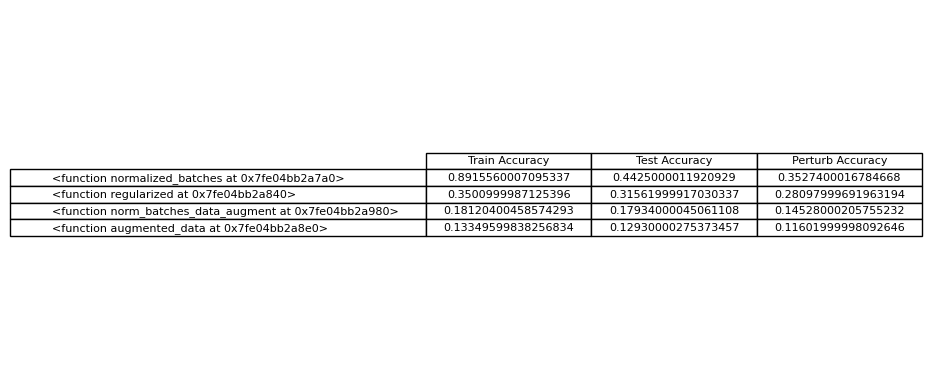

In [31]:
fix, ax = plt.subplots()
ax.axis('off')
table = pd.plotting.table(ax, df, loc='center', cellLoc='center')

So, the best Accuracy was done by normalized batches model:

Test Accuracy: $0.44250$	

Perturbed Test Accuracy: $0.35274$